In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [3]:
import collections as col

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

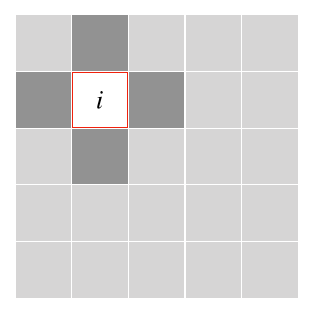 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

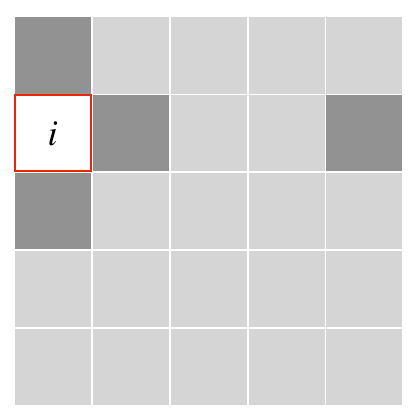 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [4]:
def create_initial_config(N=None):
    config = np.ndarray(shape=(N,N))
    for i in range(N):
        for j in range(N):
            config[i][j] = np.random.choice([1,-1])
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [5]:
config = create_initial_config(N=100)

To plot our system we can use `plt.imshow()`, as follows:

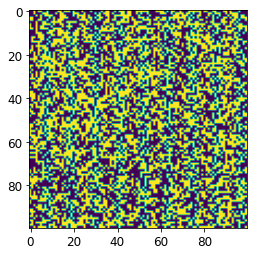

In [6]:
plt.imshow(config);

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

$$
2 J S( i , j ) \cdot [ S( i+1 , j ) + S( i-1 , j ) + S( i , j+1 ) + S( i , j-1 ) ]
$$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [48]:
def metropolis_single_update(config=None, T=None):
    # make sure config is square
    N, M = config.shape
    assert N == M
    
    # choose random site
    i = np.random.randint(0,N - 1)
    j = np.random.randint(0,N - 1)
    s =  config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2 * s * (config[(i+1)%N,j] + config[(i-1)%N,j] + config[i,(j+1)%N] + config[i,(j-1)%N])
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the sping
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = 2 * s * (config[(i+1)%N,j] + config[(i-1)%N,j] + config[i,(j+1)%N] + config[i,(j-1)%N])
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if np.random.uniform() < np.exp(-DeltaE/T):
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = 2 * s * (config[(i+1)%N,j] + config[(i-1)%N,j] + config[i,(j+1)%N] + config[i,(j-1)%N])
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

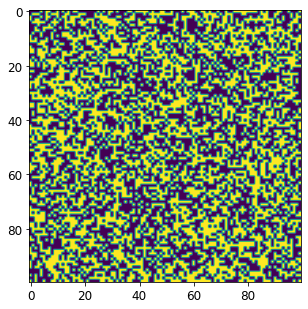

In [8]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(10000):
    # update the system
    DeltaE = metropolis_single_update(config, T=100*T_c)
    # replot every 1000 MC updates
    if t%100==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [9]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, j, i, (j-1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i, j, (i-1)%N, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1]*config[i2,j2]
    
    return E

In [10]:
get_energy(config)

-164.0

In [11]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    
    config = create_initial_config(N)
    Es = np.zeros(n_updates)
    for i in range(n_updates):
        Es[i] = get_energy(config)
        metropolis_single_update(config,T)
    
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [12]:
energy_evolution1 = get_energy_evolution(N=20, T=0.000001*T_c, n_updates=100000)
energy_evolution2 = get_energy_evolution(N=20, T=T_c, n_updates=100000)
energy_evolution3 = get_energy_evolution(N=20, T=100*T_c, n_updates=100000)

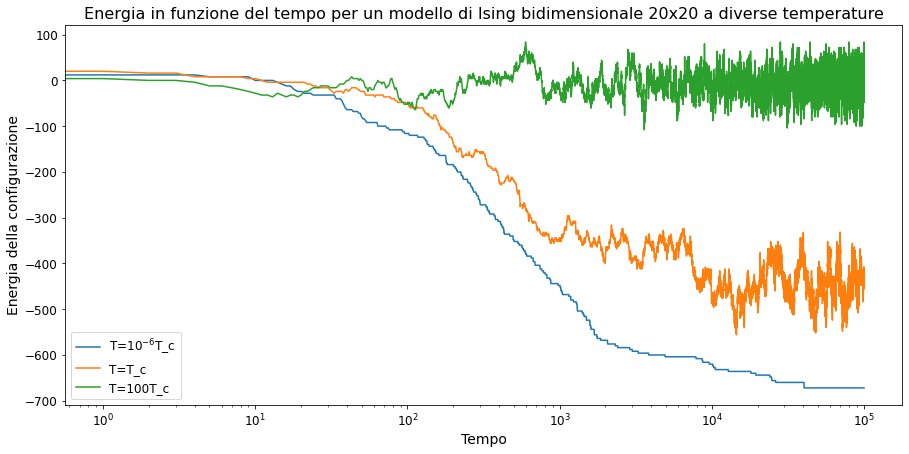

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

length = len(energy_evolution1)
time = np.arange(0,length)

ax.semilogx(time,energy_evolution1)
ax.semilogx(time,energy_evolution2)
ax.semilogx(time,energy_evolution3)

ax.set_title("Energia in funzione del tempo per un modello di Ising bidimensionale 20x20 a diverse temperature")
ax.set_xlabel("Tempo")
ax.set_ylabel("Energia della configurazione")
ax.legend(["T=$10^{-6}$T_c", "T=T_c", "T=100T_c"])

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

Come si può osservare dalle diverse linee riportate per le simulazioni a diverse temperature si può osservare che a temperature basse il sistema arriva, dopo lungo tempo, a una situazione in cui l'energia si stabilizza. Minore è la temperatura minore è il tempo in cui si raggiunge una situazione stazionaria. ciò è dovuto al fatto che il sistema si avvicina a un "congelamento". Per temperature più alte invece si osservano significative oscillazioni termiche.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [14]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [15]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [16]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

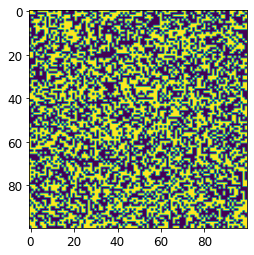

In [17]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [18]:
ising.SweepMetropolis(nTimes=1)

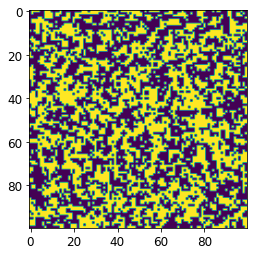

In [19]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [20]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

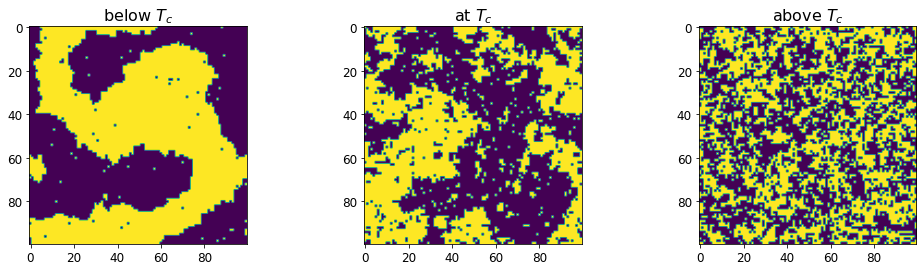

In [21]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

137 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


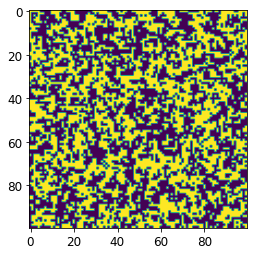

In [22]:
%%timeit
# your Ising implementation running for some number of updates
T = T_c
N = 100
config = create_initial_config(N)
for t in range(N**2):
    # update the system
    DeltaE = metropolis_single_update(config, T)
    
plt.imshow(config)

42.7 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


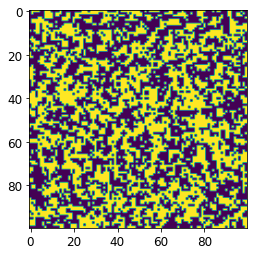

In [23]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
T = T_c
N = 100

sweep_ising = IsingModel(N = N, T = T, H = 0.)
sweep_ising.SweepMetropolis(nTimes=1)
    
plt.imshow(sweep_ising.lattice)

Come si può osservare, l'implementazione di Sethna è circa tre volte più rapida dell'implementazione da me fatta.

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

Text(0, 0.5, 'Energia')

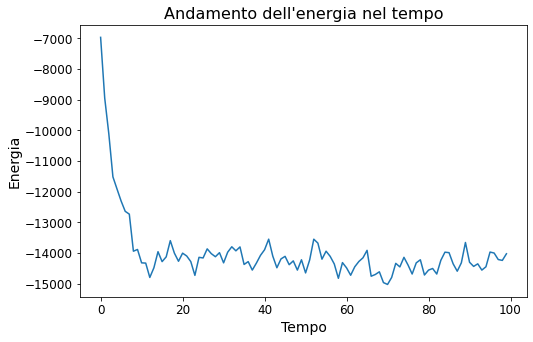

In [24]:
# set system size, temperature
T = T_c
N = 100
time = 100

ising_model0 = IsingModel(N = N, T = T, H = 0.)

M0 = np.zeros(time)
M1 = np.zeros(time)
M2 = np.zeros(time)

# run some Wolff sweeps, check if equilibrium
for i in range(time):   
    ising_model0.SweepWolff(nTimes=1)
    M0[i] = get_energy(ising_model0.lattice*2 - 1)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(M0)
ax.set_title("Andamento dell'energia nel tempo")
ax.set_xlabel("Tempo")
ax.set_ylabel("Energia")

Dal grafico riportato si può osservare che l'energia si stabilizza, all'incirca, dopo 15 sweep dell'algoritmo Wolff.

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [25]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    ising_model = IsingModel(N = system_size, T = temperature, H = 0.)
    
    # equilibrate
    for _ in range(equilibration_time):   
        ising_model.SweepWolff(nTimes=1)
        
    # compute magnetization
    ising_model.lattice = ising_model.lattice*2 - 1
    m = np.sum(ising_model.lattice)/system_size**2
    
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [26]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=50)
# system size
system_size = 64
# equilibration time
equilibration_time = 20

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = abs(calculate_magnetization(system_size, temperature, equilibration_time))
    magnetizations.append(magnetization)

Text(0, 0.5, 'Magnetizzazione')

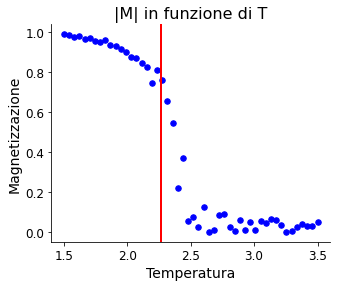

In [27]:
# define critical temperature
T_c = 2.269185314213022

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, magnetizations,
    # style keywords
    edgecolors="blue", color="blue", s=30
)
ax.axvline(
    T_c,
    # style keywords
    c="red", lw=2, ls="-"
)
ax.set_title("|M| in funzione di T")
ax.set_xlabel("Temperatura")
ax.set_ylabel("Magnetizzazione")

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

Ponendo $k_{b} = 1$ si ottiene
$$
\chi = \frac{1}{T} \cdot (\langle m^{2} \rangle - \langle m \rangle ^2)
$$
Per ottenere questa formula è necessario derivare rispetto al campo $H$ il valor medio della magnetizzazione $<m>=\frac{1}{Z}\sum_{i} s_{i}e^{\beta h_{eff}(H) s_{i}}$.

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [28]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    edges = horizontal_edges + vertical_edges
    E = 0
    
    for i1, j1, i2, j2 in edges:   
        E -= config[i1,j1]*config[i2,j2]
        
    return E / N**2

In [29]:
def compute_magnetization(ising):
    config = ising.lattice*2 - 1
    m = np.sum(config)
    
    return m

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [30]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    m_ising = IsingModel(N = system_size, T = temperature, H = 0.)
    
    # thermalize
    for _ in range(equilibration_time):
        m_ising.SweepWolff(nTimes=1)
    
    #m_ising.lattice = m_ising.lattice*2 - 1
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # get energy
        e = compute_energy(m_ising)
        es.append(e)
        # get magnetization
        m = compute_magnetization(m_ising)/(system_size**2)
        ms.append(m)
        # update system
        m_ising.SweepWolff(nTimes = 1)
    
    # compute susceptibility and specific heat
    susceptibility = np.var(ms)/temperature
    specific_heat = np.var(es)/(temperature**2)
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [31]:
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 3.5, num = 100)
# system size
system_size = 30
# equilibration time
equilibration_time = 30
# n_samples
n_samples = 100

#specific_heat
specific_heat = []
#susceptibility
susceptibility = []

# loop over temperatures, compute susceptibility and specific_heat
for T in temperatures:
    data = calculate_susceptibility_specific_heat(system_size, T, equilibration_time, n_samples)
    specific_heat.append(data[1])
    susceptibility.append(data[0])

Text(0.5, 1.0, 'Suscettibilità')

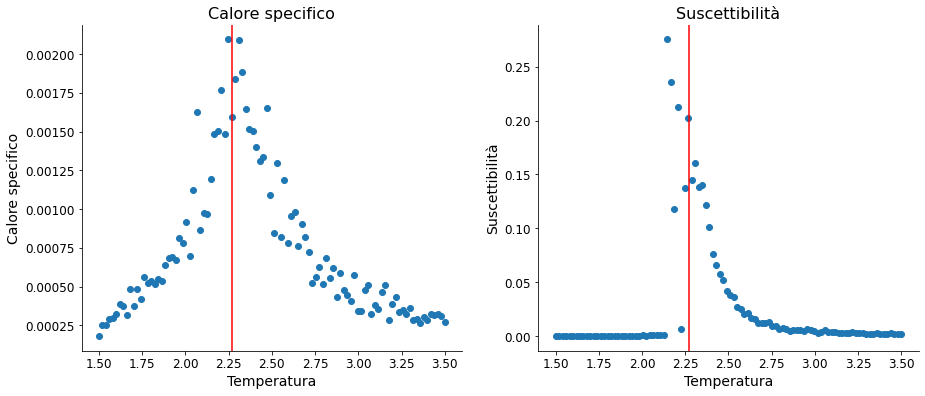

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax=ax1
ax.scatter(temperatures, specific_heat)
ax.axvline(T_c, c='red')
ax.set_ylabel("Calore specifico")
ax.set_xlabel("Temperatura")
ax.set_title("Calore specifico")

ax=ax2
ax.scatter(temperatures, susceptibility)
ax.axvline(T_c, c='red')
ax.set_ylabel("Suscettibilità")
ax.set_xlabel("Temperatura")
ax.set_title("Suscettibilità")


### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

Nel limite termodinamico, l'andamento del calore specifico e della suscettibilità magnetica sarebbero delle delta di Dirac. Intengrando queste grandezze per ottenere il valore dell'energia, quest'ultima presenta, dunque, una discontinuità in T = T_c. Nella presente simulazione, si può osservare come, data la finitezza del sistema, $C$ e $\chi$ siano "smussate". Tuttavia, tali andamenti in funzione della temperatura danno luogo a una crescita più o meno ripida nell'andamento dell'energia in funzione di T che rispecchia, appunto, l'andamento visto nel caso di limite termodinamico. 

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

Trasformo la matrice di ising in matrice di 0 e 1. Tramite il comando nonzeros trovo le posizioni degli 1 e poi il complementare. Salvo le posizioni degli 1 in ones, degli 0 in zeros. 

Prendo il primo elemento di ones, con relativa etichetta. 
    Controllo nella matrice i 4 vicini.
    Salvo un vettore contenente i vicini.
    Stessa etichetta.
    Elimino questi vicini dal vettore di ones.
    first_elements con i 4 vicini
    controlli i vicini dei vicini -> next_next_elements e ripeto.
    Quando next_elements è vuoto posso passare a un nuovo ciclo totale
    Ripeto sul nuovo secondo elemento di ones
    
Ripeto la stessa operazione su zeros facendo andare sempre avanti l'etichetta.

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

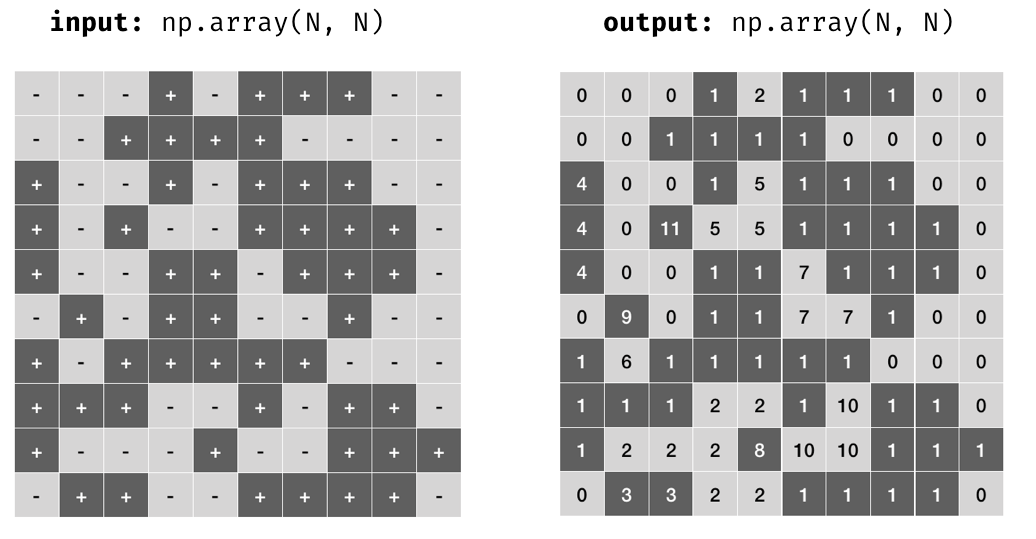

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [33]:
def get_labels(config):

    config_dimension = np.shape(config)
    
    label = 1
    
    config = config + 1
    ones = np.transpose(np.nonzero(config))
    config = config - 2
    zeros = np.transpose(np.nonzero(config))
    indices = np.vstack((ones,zeros))
    
    output_matrix = np.zeros((np.shape(config)[0],np.shape(config)[1])) 
    
    while np.any(output_matrix == 0) == True:
        
        row = np.random.randint(0,np.shape(indices)[0])
        first_element = indices[row][:]
        indices = np.delete(indices, row, 0)
        next_elements = np.zeros(2)
        if output_matrix[first_element[0]][first_element[1]] == 0:     
        
            output_matrix[int(first_element[0])][int(first_element[1])] = label
            possible_labels = np.array([[(first_element[0] + 1)%config_dimension[0], first_element[1]],
                                    [(first_element[0] - 1)%config_dimension[0], first_element[1]],
                                    [first_element[0], (first_element[1] + 1)%config_dimension[0]],
                                    [first_element[0], (first_element[1] - 1)%config_dimension[0]]])

            for neighbor in possible_labels:
                if config[int(neighbor[0])][int(neighbor[1])] == config[int(first_element[0])][int(first_element[1])] and output_matrix[int(neighbor[0])][int(neighbor[1])] == 0:
                    next_elements = np.vstack((next_elements, neighbor))
                    output_matrix[int(neighbor[0])][int(neighbor[1])] = label
            next_elements = np.delete(next_elements, 0, 0)
            first_element = next_elements
            
            the_stop = np.array([0.])
            while np.all(np.shape(next_elements) != np.shape(the_stop)) == True:
                next_elements = np.zeros(2)

                for element in first_element:
                    possible_labels = np.array([[(element[0] + 1)%config_dimension[0], element[1]],
                                                    [(element[0] - 1)%config_dimension[0], element[1]],
                                                    [element[0], (element[1] + 1)%config_dimension[0]],
                                                    [element[0], (element[1] - 1)%config_dimension[0]]])

                    for neighbor in possible_labels:
                        if config[int(neighbor[0])][int(neighbor[1])] == config[int(element[0])][int(element[1])] and output_matrix[int(neighbor[0])][int(neighbor[1])] == 0:
                            next_elements = np.vstack((next_elements, neighbor))
                            output_matrix[int(neighbor[0])][int(neighbor[1])] = label

                next_elements = np.delete(next_elements, 0, 0)
                first_element = next_elements

            label += 1
    
    number_of_cluster = label - 1
    return output_matrix

In [34]:
%%time
x = config
print(x)
cavoletto=get_labels(x)

[[-1. -1. -1. ... -1. -1.  1.]
 [-1.  1.  1. ... -1.  1. -1.]
 [ 1. -1. -1. ... -1.  1.  1.]
 ...
 [ 1. -1.  1. ... -1.  1.  1.]
 [-1. -1.  1. ... -1. -1. -1.]
 [ 1. -1.  1. ...  1. -1.  1.]]
CPU times: user 432 ms, sys: 3.38 ms, total: 435 ms
Wall time: 435 ms


### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [35]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [36]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [37]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

CPU times: user 80.4 ms, sys: 1.51 ms, total: 81.9 ms
Wall time: 81 ms


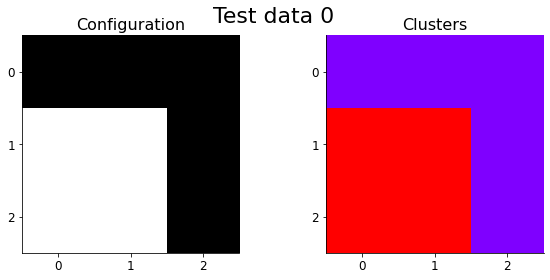

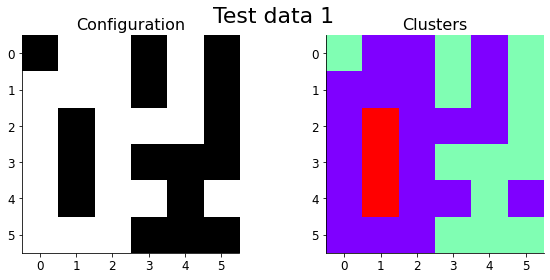

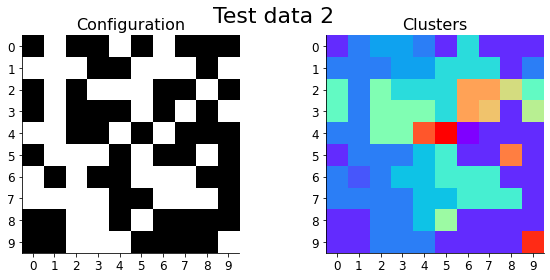

In [38]:
%%time
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels=get_labels(config)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<AxesSubplot:>

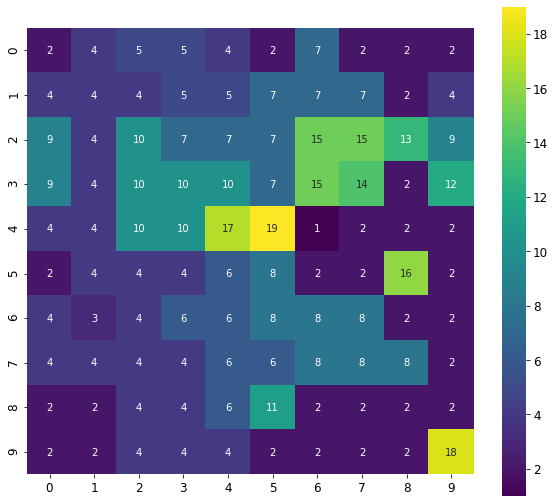

In [39]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [40]:
%%time
config1 = create_initial_config(N = 500)
labels1 = get_labels(config1)

CPU times: user 38.7 s, sys: 235 ms, total: 39 s
Wall time: 39 s


33087.0


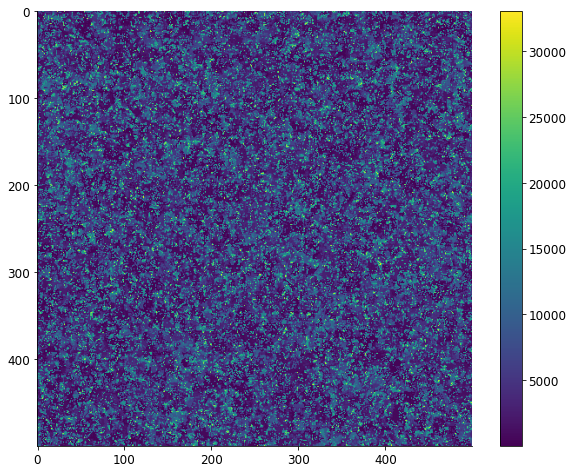

In [41]:
plt.figure(figsize=(10, 8))
plt.imshow(labels1)
print(np.max(labels1))
cbar=plt.colorbar()

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [42]:
def get_sizes(labels):
    labels_reshaped = np.reshape(labels, (np.shape(labels)[0]**2))
    number_of_clusters = np.amax(labels_reshaped)
    l = 1
    counter = col.Counter(labels_reshaped)
    size = np.zeros(1, dtype = int)
    while l <= number_of_clusters:
        cluster_dimension = counter[l]
        size = np.append(size, cluster_dimension)
        l += 1
    size = np.delete(size, 0, 0)
    return size

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

Dato che gli spin sono scorrelati mi aspetto che la distribuzione della dimensione dei clusters sia piccata su valori piccoli e che decresca rapidamente al crescere di tale dimensione.

### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

Come si può osservare nel grafico sotto riportato la distribuzione della dimensione dei cluster sembra seguire una legge di potenza. Ciò è in accordo con quanto scritto al punto precedentemente. 

In [43]:
%%time
T_c = 2/np.log(1+np.sqrt(2))

T = 1000*T_c
N = 500
time = 30
m_Ising = IsingModel(N = N, T = T, H = 0.)

for _ in range(time):   
    m_Ising.SweepWolff(nTimes=1)
m_Ising.lattice = m_Ising.lattice*2 - 1
labels = get_labels(m_Ising.lattice)
sizes = get_sizes(labels)

CPU times: user 1min 39s, sys: 694 ms, total: 1min 39s
Wall time: 1min 39s


Text(0.5, 0, 'Dimensione dei cluster')

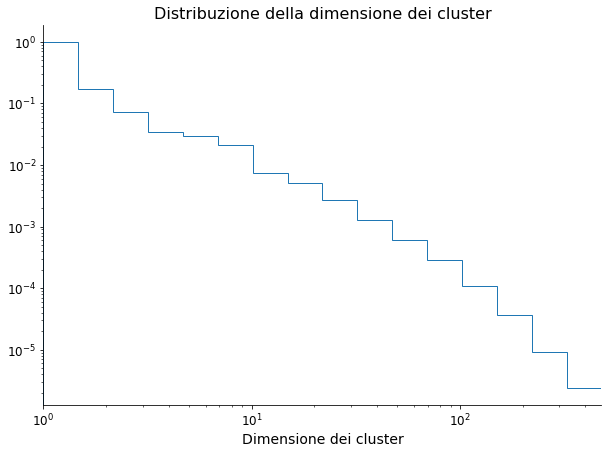

In [44]:
# use logarithmic bins and logarithmic axes!
bins = np.geomspace(min(sizes), max(sizes), num=17)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.hist(sizes, bins=bins, histtype="step", density = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))
ax.set_title("Distribuzione della dimensione dei cluster")
ax.set_xlabel("Dimensione dei cluster")

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [45]:
# do simulation
T = T_c
N = 500
time = 30
m_Ising_at_T_c = IsingModel(N = N, T = T, H = 0.)

for _ in range(time):   
    m_Ising_at_T_c.SweepWolff(nTimes=1)

m_Ising_at_T_c.lattice = m_Ising_at_T_c.lattice*2 - 1

line_1 = []
line_2 = []
line_3 = []

labels_at_T_c = get_labels(m_Ising_at_T_c.lattice)
sizes_at_T_c = get_sizes(labels_at_T_c)
for i in sizes_at_T_c:
    line_2.append(1/i**(2))
    line_3.append(1/i**(3))
    line_1.append(1/i**(1))

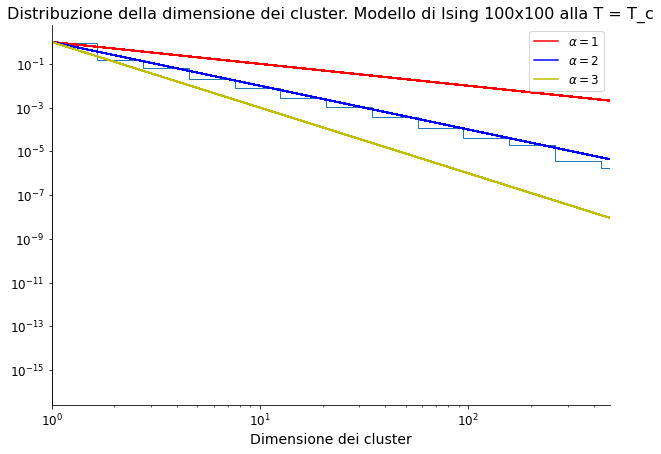

In [46]:
# plot results
bins = np.geomspace(min(sizes_at_T_c), max(sizes_at_T_c), num=25)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.hist(sizes_at_T_c, bins=bins, histtype="step", density = True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))
ax.plot(sizes_at_T_c, line_1, 'r')
ax.plot(sizes_at_T_c, line_2, 'b')
ax.plot(sizes_at_T_c, line_3, 'y')

ax.set_title("Distribuzione della dimensione dei cluster. Modello di Ising 100x100 alla T = T_c")
ax.set_xlabel("Dimensione dei cluster")
ax.legend([r"$\alpha=1$", r"$\alpha=2$", r"$\alpha=3$"])

Text(0.5, 1.0, 'Confronto della distribuzione delle dimenisoni dei cluster a differenti temperature')

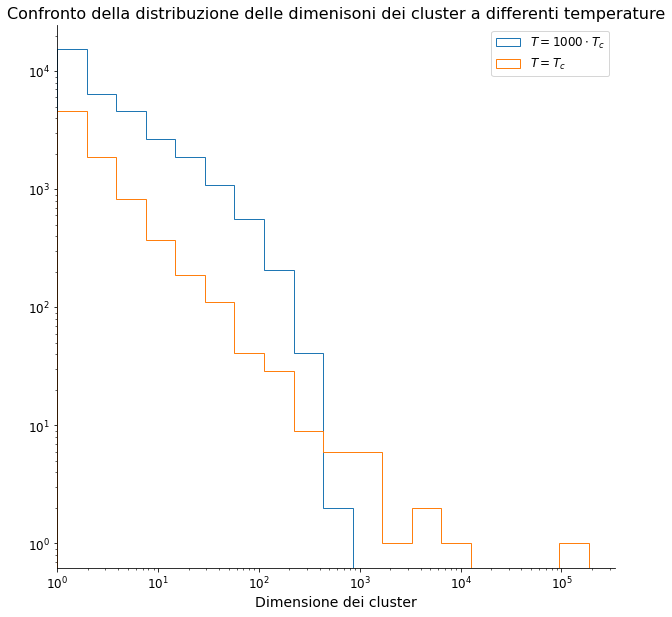

In [47]:
bins_3 = np.geomspace(min(sizes_at_T_c), max(sizes_at_T_c), num=19)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.hist(
    sizes, 
    bins=bins_3, 
    histtype="step", 
    density=False,
    label=r"$T=1000 \cdot T_c$"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Dimensione dei cluster") 

ax.hist(
    sizes_at_T_c, 
    bins=bins_3, 
    histtype="step", 
    density=False,
    label=r"$T=T_c$"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Dimensione dei cluster") 

ax.set_xlim(min(sizes))
ax.legend( frameon=True)
ax.set_title(f"Confronto della distribuzione delle dimenisoni dei cluster a differenti temperature")
